In [122]:
# Assign values to variables
C = 6.69810502993
V_1 = 30
V_2 = 15
V_3 = 0
V_4 = 30
phi = 0.025
V_L = -50
V_Ca = 100
V_K = -70
g_Ca = 1.1
g_K = 2
g_L = 0.5
V = -52.14
N = 0.02

In [133]:
import numpy as np

scale = 0.5
length = 1000
center = 0.5
current = list(scale * np.random.random((length)) + center)

In [124]:
#Define functions
M_ss = lambda: (1/2) * (1 + np.tanh((V - V_1) / V_2))
N_ss = lambda: (1/2) * (1 + np.tanh((V - V_3) / V_4))
T_N = lambda: 1 / (phi * np.cosh((V - V_3) / (2 * V_4)))

#Define differential equations
dV = lambda I: (I - g_L * (V - V_L) - g_Ca * M_ss() * (V - V_Ca) - g_K * N * (V - V_K)) / C
dN = lambda: (N_ss() - N) / T_N()

#Equations for the input of each channel
L = lambda: - g_L * (V - V_L)
Ca = lambda: - g_Ca * M_ss() * (V - V_Ca)
K = lambda: - g_K * N * (V - V_K)

In [134]:
import pandas as pd

#Pandas DataFrame to store variables
base_data = {
    "t" : [],
    "I" : [],
    "V" : [],
    "N" : [],
    "L" : [],
    "Ca" : [],
    "K" : [],
    "N_ss" : [],
    "T_N" : []
}
data = base_data

for t, I in zip(range(len(current)), current):
	#Update variables
	V = V + dV(I)
	N = N + dN()
	#Update DataFrame
	data["t"].append(t)
	data["I"].append(I)
	data["V"].append(V)
	data["N"].append(N)
	data["L"].append(L())
	data["Ca"].append(Ca())
	data["K"].append(K())
	data["N_ss"].append(N_ss())
	data["T_N"].append(T_N())

data = pd.DataFrame.from_dict(data)

In [126]:
data.head()

,Ca,I,K,L,N,N_ss,T_N,V,t
0,0.002981,0.517194,-0.732546,1.004629,0.020359,0.030258,28.575303,-52.009258,0
1,0.003043,0.800285,-0.752035,0.924356,0.020716,0.030573,28.628805,-51.848712,1
2,0.003097,0.751501,-0.770693,0.855168,0.021069,0.030848,28.674914,-51.710335,2
3,0.003159,0.962400,-0.790260,0.776789,0.021420,0.031162,28.727144,-51.553579,3
4,0.003208,0.835436,-0.808435,0.715196,0.021768,0.031411,28.768184,-51.430391,4


C:\Users\jonathan\Anaconda3\lib\site-packages\matplotlib\__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


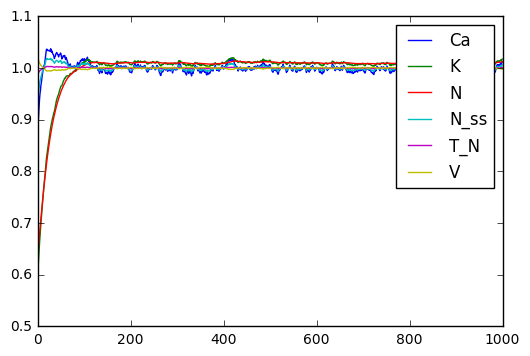

In [127]:
%matplotlib inline
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt

for col in data.keys():
    if col in ["t", "I", "L"]: continue
    plt.plot(data[col]/np.mean(data[col]))
    plt.legend()
plt.show()

In [128]:
value = 0.5
length = 1000
current = [value for _ in range(length)]

In [129]:
data = base_data

for t, I in zip(range(len(current)), current):
	#Update variables
	V = V + dV(I)
	N = N + dN()
	#Update DataFrame
	data["t"].append(t)
	data["I"].append(I)
	data["V"].append(V)
	data["N"].append(N)
	data["L"].append(L())
	data["Ca"].append(Ca())
	data["K"].append(K())
	data["N_ss"].append(N_ss())
	data["T_N"].append(T_N())
    
data = pd.DataFrame.from_dict(base_data)

In [130]:
data.head()

,Ca,I,K,L,N,N_ss,T_N,V,t
0,0.002981,0.517194,-0.732546,1.004629,0.020359,0.030258,28.575303,-52.009258,0
1,0.003043,0.800285,-0.752035,0.924356,0.020716,0.030573,28.628805,-51.848712,1
2,0.003097,0.751501,-0.770693,0.855168,0.021069,0.030848,28.674914,-51.710335,2
3,0.003159,0.962400,-0.790260,0.776789,0.021420,0.031162,28.727144,-51.553579,3
4,0.003208,0.835436,-0.808435,0.715196,0.021768,0.031411,28.768184,-51.430391,4


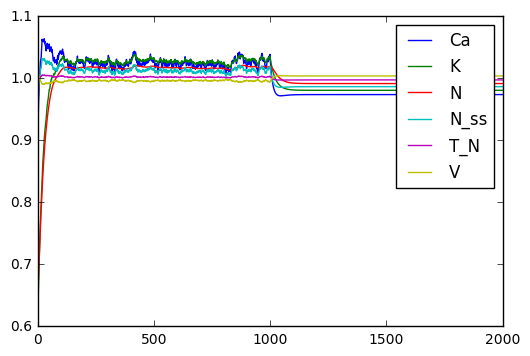

In [131]:
for col in data.keys():
    if col in ["t", "I", "L"]: continue
    plt.plot(data[col]/np.mean(data[col]))
    plt.legend()
plt.show()